<a href="https://colab.research.google.com/github/angelomarcelino/machine_learning/blob/main/q6_NARX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importações

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from pyneurgen.neuralnet import NeuralNet
from pyneurgen.recurrent import NARXRecurrent

# Questão 6

Considere o problema de predição de uma série temporal definida como $x(n) = v(n) + \beta v(n-1)v(n-2)$, com média zero e variância dada por $\sigma_{x}^2 = \sigma_{v}^2 + \beta^2\sigma_{v}^2$ onde $v(n)$ é um ruído branco gaussiano, como variância unitária e $\beta = 0.5$. Utilizando uma rede NARX estime $x(n+1)=f(x(n), x(n-1), x(n-2), x(n-3),y(n), y(n-1), y(n-2))$. Esboce a curva da série e a curva de predição em função em função de n. Esboce também o erro de predição. Calcule a variância da predição e compare com a variância da série temporal. No treinamento utilize a estratégia da resposta forçada do professor. Isto é na estimativa de $x(n+1)=f(x(n), x(n-1), x(n-2), x(n-3),d(n), d(n-1),d(n-2))$. Onde $d(n)$ é resposta desejada.

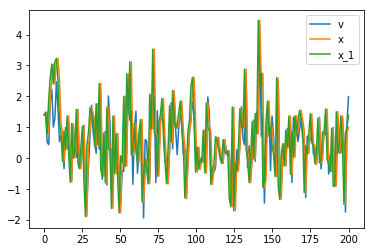

In [2]:
# Definindo v(n)
np.random.seed(8008135)
mean = 0.5
std = 1
n = 200
v = np.random.normal(mean, std, size=n)

# Definindo x(n)
inputs = []
for i in range(n):
    a = 0 if i-1 < 0 else v[i-1]
    b = 0 if i-2 < 0 else v[i-2]
    inputs.append(v[i] + 0.5*a*b)
    
inputs_1 = inputs[1:]
inputs_1.append(inputs[0])

plt.plot(np.linspace(0,n,n), v, label='v')
plt.plot(np.linspace(0,n,n), inputs, label='x')
plt.plot(np.linspace(0,n,n), inputs_1, label='x_1')
plt.legend()
plt.show()



In [3]:
def plot_results(x, y_true, y_predict):
    
    plt.subplot(3, 1, 1)
    plt.plot([i[1] for i in population])
    plt.title("Input")
    plt.ylim((-2,5))
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot([i[2] for i in population], 
            label="Desired output",
            alpha=0.3)
    plt.plot(x, y_true, 'bo-', label='True')
    plt.plot(x, y_predict, 'ro-', label='Predict')
    plt.grid(True)
    plt.legend(loc='lower left', numpoints=1)
    plt.title("Test Predict Points vs True Points")
    plt.ylim((-2,5))

    plt.subplot(3, 1, 3)
    plt.plot(range(1, len(net.accum_mse) + 1, 1), net.accum_mse)
    plt.xlabel('epochs')
    plt.ylabel('mean squared error')
    plt.grid(True)
    plt.title("Mean Squared Error by Epoch")
    plt.show()
    
def generate_data(pop_len=200):
    # all samples are drawn from this population
    np.random.seed(8008135)
    mean = 0.5
    std = 1
    v = np.random.normal(mean, std, size=pop_len)
    population = []
    for i in range(pop_len):
        a = 0 if i-1 < 0 else v[i-1]
        b = 0 if i-2 < 0 else v[i-2]
        c = i+1 if i+1 < pop_len else -1
        population.append([i, v[i] + 0.5*a*b, v[c] + 0.5*a*b])
    population_shuffle = population[:]
    
    all_inputs = []
    all_targets = []

    np.random.shuffle(population_shuffle)
    for index, inputs, inputs_1 in population_shuffle:
        all_inputs.append([index, inputs])
        all_targets.append([index, inputs_1])

    return population, all_inputs, all_targets 

In [4]:
# generate data
population, all_inputs, all_targets =  generate_data(200)

input_nodes = 1
hidden_nodes = [8,4,2]
output_nodes = 1

output_order = 3
incoming_weight_from_output = .6
input_order = 3
incoming_weight_from_input = .4

# init neural network
net = NeuralNet()
net.init_layers(input_nodes, hidden_nodes, output_nodes,
                NARXRecurrent(output_order, incoming_weight_from_output, 
                              input_order, incoming_weight_from_input))
net.randomize_network()
net.set_halt_on_extremes(True)

# set constrains and rates
net.set_random_constraint(.5)
net.set_learnrate(.01)

# set inputs and outputs
inputs = [[inp[1]] for inp in all_inputs]
targets = [[tar[1]] for tar in all_targets]
net.set_all_inputs(inputs)
net.set_all_targets(targets)

# set lengths
length = len(all_inputs)
learn_end_point = int(length * .8)

# set ranges
net.set_learn_range(0, learn_end_point)
net.set_test_range(learn_end_point + 1, length - 1)

# add activation to layer 1
net.layers[1].set_activation_type('tanh')


In [5]:
# fit data to model
net.learn(epochs=200, show_epoch_results=True, random_testing=False)

epoch: 0 MSE: 0.6012697278853922
epoch: 1 MSE: 0.5907387267162812
epoch: 2 MSE: 0.5904822580492427
epoch: 3 MSE: 0.5901850255027197
epoch: 4 MSE: 0.5898894381501503
epoch: 5 MSE: 0.5896075963014076
epoch: 6 MSE: 0.5893388386912847
epoch: 7 MSE: 0.5890813309820065
epoch: 8 MSE: 0.588833257976152
epoch: 9 MSE: 0.5885929188637177
epoch: 10 MSE: 0.5883587173684861
epoch: 11 MSE: 0.5881291435906127
epoch: 12 MSE: 0.5879027565862731
epoch: 13 MSE: 0.5876781682127457
epoch: 14 MSE: 0.5874540279803003
epoch: 15 MSE: 0.5872290086115048
epoch: 16 MSE: 0.5870017920321777
epoch: 17 MSE: 0.5867710555405339
epoch: 18 MSE: 0.586535457916818
epoch: 19 MSE: 0.5862936252452388
epoch: 20 MSE: 0.5860441362244136
epoch: 21 MSE: 0.5857855067426397
epoch: 22 MSE: 0.5855161734911908
epoch: 23 MSE: 0.5852344763837172
epoch: 24 MSE: 0.5849386395441527
epoch: 25 MSE: 0.5846267506213072
epoch: 26 MSE: 0.5842967381883154
epoch: 27 MSE: 0.583946346993111
epoch: 28 MSE: 0.5835731108474955
epoch: 29 MSE: 0.5831743229

Testing mse =  0.6083261416010032


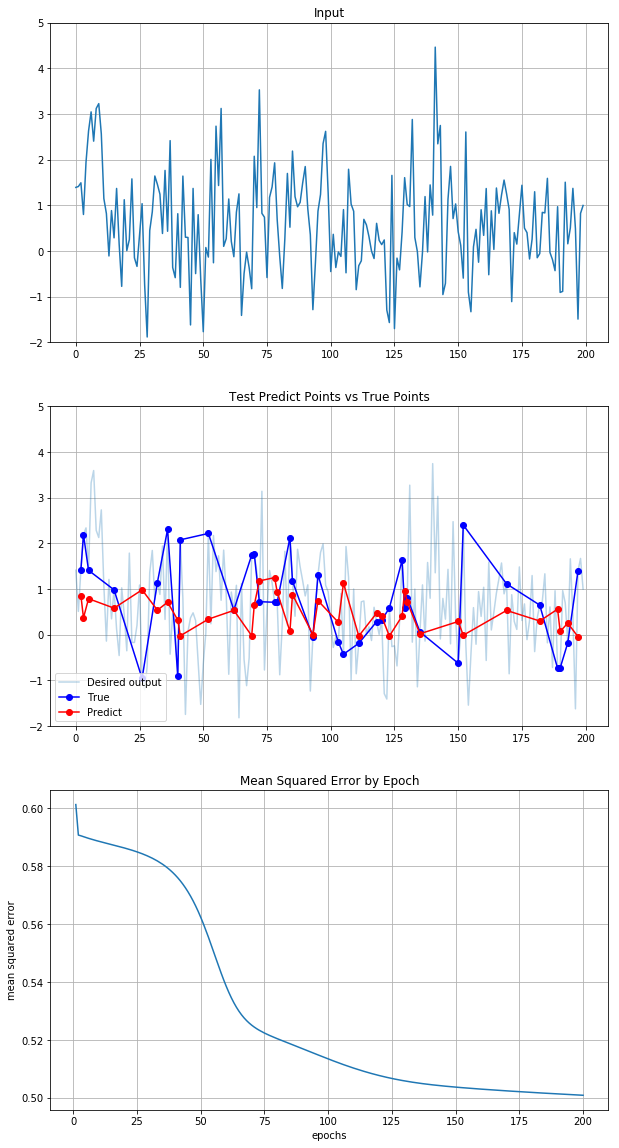

<Figure size 432x288 with 0 Axes>

In [7]:
# define mean squared error
mse = net.test()
print "Testing mse = ", mse

fig = plt.figure(figsize=(10,20))

# define data
y_true = [item[0][0] for item in net.test_targets_activations]
y_predict = [item[1][0] for item in net.test_targets_activations]
x=[]
for value in y_true:
    for item in all_targets:
        try:
            item.index(value)
            x.append(item[0])
        except ValueError:
            continue
            
zipped = zip(x, y_true, y_predict)
zipped.sort()
x, y_true, y_predict = zip(*zipped)

# plot results
plot_results(x, y_true, y_predict)
plt.savefig('narx.eps')